<h1>Relating Vaccination Rates to Measles Outbreaks</h1>
<p>Lena</p>

<h2>Question</h2>
    <p>What vaccination rate will prevent an outbreak of measles among elementary-aged children?</p>

The United States was officially declared to have eliminated measles in the year 2000. However, this status was almost lost after a year-long breakout of 654 cases in Brooklyn, New York. In the last year, Albania, Czech Republic, Greece and the United Kingdom have all lost their elimination status. According to the WHO, vaccine rates have stagnated worldwide over the last ten years. As fears arise surrounding vaccination, we will use modeling to verify their necessity. 

<h2>Model</h2>

This model will be based on an SIR model. Since the measles vaccine is only 97% effective, it will separate the susceptible and infected populations into vaccinated and unvaccinated groups, with 2 stocks for both. This way, we can keep track of how the outbreak affects each group.

Our model takes several pieces of data about children aged 5-15, including the rate of infection for the vaccinated susceptible population, the rate of infection for the unvaccinated susceptible population, the death rates of both of these populations, and the recovery rates of both populations. 

To find the unvaccinated rate of infection, we multiply the transmission rate per contact by the average contact rate. Children have a relatively high contact rate of about 16 children per day. Measles has an extremely high tranmission rate, with a 90% chance of transmission per contact. Since we could not find an exact infection rate for the vaccinated population, we found data asserting that 2 doses of the MMR vaccine reduces the rate of transmission by 97% and multiplied the rate of transmission by .03 to find the vaccinated transmission rate of 0.027 transissions per contact. We assumed that the vaccinated population received both doses, since this is true for almost all American vaccinated children under the age of 10. 

I found the death rate of measles in the US to be about 1 death per 1000 cases. This corresponds to a death rate of 0.000059 after dividing by the duration of the disease. Finding specific data for the death rates of an vaccinated vs unvaccinated population proved difficult, so I had to rely on assumptions. First, in wealthier countries with widespread access to medicine, measles is rarely fatal. When a vaccinated person contracts the disease, there are fewer symptoms and it sometimes just resembles a cold. Therefore, I assumed the vaccinated population to have a death rate of 0 cases per 1000 for measles. This assumptions works as long as we are working with these countries.

I found the recovery rate for unvaccinated children by simply subtracting the death rate from 1 to get 999 recoveries per 1000 cases, then divided that by the duration of the disease to find the actual recovery rate. Since my vaccinated death rate for vaccinated children is 0, my recovery rate will simply be 1/17. 

In [148]:
# Configure Jupyter so figures appear in the notebook
%matplotlib inline

# Configure Jupyter to display the assigned value after an assignment
%config InteractiveShell.ast_node_interactivity='last_expr_or_assign'

# import functions from the modsim.py module
from modsim import *
from pandas import read_csv

In [149]:
def make_system(t_end, S_init, I_init, vax_rate):
    """ 
    Makes a system object
        
    t_0: First day of outbreak 
    t_end: Last day of predictions
    S: Susceptible unvaccinated children
    VS: Susceptible vaccinated children
    I: Infected unvaccinated children
    VI: Infected vaccinated children
    D: Deceased children
    R: Recovered children
    
    returns: System object
    """
    
    contact_rate = 16
    
    i_rate = 0.9 * contact_rate # rate of transmission per contact x contact rate 
    vi_rate = 0.027 * contact_rate # rate of transmission per contact x contact rate 
    d_rate =0.000059 # deaths per 1000 cases / duration of disease (17 days)
    vd_rate =0.0000 # deaths per 1000 cases / duration of disease 
    r_rate =0.05876 # recoveries per 1000 cases / duration of disease 
    vr_rate =0.05882 # recoveries per 1000 cases / duration of disease 
    
    
    # initial vaccinated vs unvaccinated susceptible populations calculated with vaccination rate
    init = State(S = (S_init - S_init*vax_rate), VS = S_init*vax_rate, I = I_init, VI = 0, D = 0, R = 0)
    t_0 = 0
    
    

    return System(init=init, t_0=t_0, t_end=t_end, vax_rate = vax_rate, i_rate = i_rate, vi_rate = vi_rate, d_rate = d_rate, vd_rate = vd_rate, r_rate = r_rate, vr_rate = vr_rate)  

In [150]:
def update_func(state, t, system):
    """
    Updates the model after 1 timestep (1 day)
    
    state: State object (S,VS,I,VI,D,R)
    time: Time (day)
    system: System object
    
    returns: State object(S,VS,I,VI,D,R)
    """
    unpack(system)
    s, vs, i, vi, d, r = state
    
    pop = s + vs + i + vi + r

    def min(x,y):
        if x>y:
            return y
        return x
        
    
    # min(x,y) keeps the total population static
    
    dSdt = -min(s, (i_rate)*(i+vi)*(s/pop)) # infection rate x total infected population x susceptible fraction of population
    dVSdt = -min(vs,(vi_rate)*(i+vi)*(vs/pop)) # infection rate x total infected population x vaccinated fraction of population
    dIdt = -dSdt - (d_rate)*i - (r_rate)*i # new infections - deaths and recoveries
    dVIdt = -dVSdt - (vd_rate)*vi - (vr_rate)*vi # new infections - deaths and recoveries
    dDdt = (d_rate)*i # assume no deaths in vaccinated pop
    dRdt = (r_rate)*i + (vr_rate)*vi


    s += dSdt
    vs += dVSdt
    i += dIdt
    vi += dVIdt
    d += dDdt
    r += dRdt

    
    return State(S = s, VS = vs, I = i, VI = vi, D = d, R = r)

To calculate the number of new infections in each time step, we multiple the probability that one infected person will infect a non-infected susceptible person, i_rate, by s/pop, the likelihood that a person is non-infected susceptible,  and i+vi, the number of infected people. If that value is greater than the number of susceptible people left in the population, we set the number of new infections to the number of susceptible people.

In [151]:
def run_simulation(system, update_func):
    """
    Runs a simulation of the system
    
    system: System object
    update_func: Function to update state object
    
    returns: TimeFrame
    """
    frame = TimeFrame(columns=system.init.index)
    frame.row[system.t_0] = system.init
    

    for t in linrange(system.t_0, system.t_end):
        frame.row[t+1] = update_func(frame.row[t], t, system)
    
    return frame

In [152]:
def plot_results(results):
    """
    Plots results of model
    
    S: TimeSeries
    VS: TimeSeries
    I: TimeSeries
    VI: TimeSeries
    D: TimeSeries
    R: TimeSeries

    """
    plot(results.S, '--', label='Susceptible children')
    #plot(results.VS, '-', label='Vaccinated children')
    #plot(results.I, ':', label='Infected children')
    plot(results.VI + results.I, ':', label='Infected children')
    plot(results.D, ':', label='Deceased children')
    plot(results.R, ':', label='Recovered children')

    decorate(xlabel='Time (days)',
             ylabel='Number of children', title = "Breakdown of Pop vs Time")

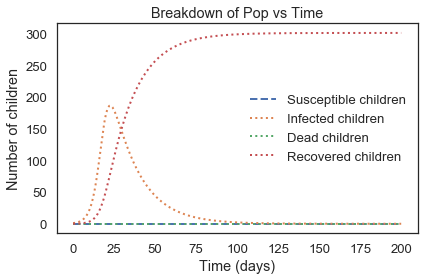

In [153]:
system = make_system(200,300,1, 1)
results = run_simulation(system, update_func)

plot_results(results)

The model predicts that within 100 days, every student in  will become infected with measles, even with a vaccination rate of 100%. This cannot be true, otherwise all of Brooklyn would be sick with measles right now. Currently, the model assumes the contagious period of measles to be 17 days, which is the entire duration of the illness. In reality, people are contagious for about 7 days. The contagious period lasts from about 10-12 days after the moment of infection, until 4 days after the rash appears, which is about 17 days after the moment of infection. Therefore, our model assumes the contagious period to be more than twice what it actually is, thus overestimating the number of infection transmissions.

<h1>Iteration 2</h1>

The next iteration of the model will separate those who are infected and those who are contagious. We assume that an infected person is not contagious for the first 10 days of the infection and contagious for the following 7 days. This gives us a contagious rate c_rate of 1/10 and new recovery rates r_rate and vr_rate of about 1/7.

In [154]:
def make_system2(t_end, S_init, I_init, vax_rate):
    """ 
    Makes a system object
        
    t_0: First day of outbreak
    t_end: Last day of predictions
    S: Susceptible unvaccinated children
    VS: Susceptible vaccinated children
    I: Infected unvaccinated children
    VI: Infected vaccinated children
    C: Contagious children
    D: Deceased children
    R: Recovered children
    
    returns: System object
    """
    
    contact_rate = 16
    
    i_rate = 0.9 * contact_rate
    vi_rate = 0.027 * contact_rate
    d_rate =0.000059
    vd_rate =0.0000
    c_rate = 0.1 # takes 10 days to reach contagious period
    r_rate =0.1427 # takes 7 days in contagious period to recover
    vr_rate =0.1428
    
    
     
    init = State(S = (S_init - S_init*vax_rate), VS = S_init*vax_rate, I = 0, VI = 0, C = I_init , D = 0, R = 0)
    t_0 = 0
    
    

    return System(init=init, t_0=t_0, t_end=t_end, vax_rate = vax_rate, i_rate = i_rate, vi_rate = vi_rate, d_rate = d_rate, vd_rate = vd_rate, c_rate = c_rate, r_rate = r_rate, vr_rate = vr_rate)  

In [155]:
def update_func2(state, t, system):
    """
    Updates the model after 1 timestep (1 day)
    
    state: State object (S,VS,I,VI,C,D,R)
    time: Time (day)
    system: System object
    
    returns: State object(S,VS,I,VI,C,D,R)
    """
    unpack(system)
    s, vs, i, vi, c, d, r = state
    
    pop = s + vs + i + vi + r + c

    def min(x,y):
        if x>y:
            return y
        return x
    

    
    dSdt = -min(s, (i_rate)*(c)*(s/pop))
    dVSdt = -min(vs, (vi_rate)*(c)*(vs/pop))
    dIdt = -dSdt - (c_rate)*(i)
    dVIdt = -dVSdt - (c_rate)*(vi)
    dCdt = (c_rate)*(i+vi) - (d_rate)*c - (r_rate)*c - (vd_rate)*c - (vr_rate)*c
    dDdt = (d_rate)*c + (vd_rate)*c
    dRdt = (r_rate)*c + (vr_rate)*c


    s += dSdt
    vs += dVSdt
    i += dIdt
    vi += dVIdt
    c += dCdt
    d += dDdt
    r += dRdt

    
    return State(S = s, VS = vs, I = i, VI = vi, C = c, D = d, R = r)

In [156]:
def plot_results2(results):
    """
    Plots results of model
    
    S: TimeSeries
    VS: TimeSeries
    I: TimeSeries
    VI: TimeSeries
    C: Contagious
    D: TimeSeries
    R: TimeSeries

    """
    plot(results.S, '--', label='Susceptible children')
    #plot(results.VS, '-', label='Vaccinated children')
    plot(results.I, ':', label='Infected children')
    plot(results.VI , '--', label='Infected vax children')
    plot(results.D, ':', label='Deceased children')
    plot(results.C, '-', label = 'Contagious children')
    plot(results.R, ':', label='Recovered children')

    decorate(xlabel='Time (days)',
             ylabel='Number of children', title = "Breakdown of Pop vs Time")

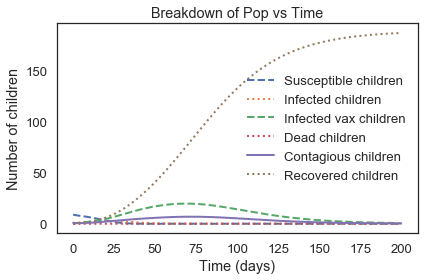

In [158]:
system = make_system2(200,300,1,.97)
results = run_simulation(system, update_func2)

plot_results2(results)

The second model predicts that a little over half of the population of the school will become infected throughout the 250-day span of the outbreak. This is better, but still a big overestimation. Our model assumes that children who are contagious will continue to attend school, even after showing symptoms. In reality, a child who is infected with measles will stay home from school as soon as symptoms show and the child is diagnosed. 

<h1>Iteration 3</h1>

The third iteration of the model will keep children 'quarantined' at home after 2 days of being contagious. We assume that an infected person will stay home when they beging showing symptoms, about 2 days into the contagious period. This gives us quarantine rate of 0.5 and new recovery rates r_rate and vr_rate of about 1/5.

In [159]:
def make_system3(t_end, S_init, I_init, vax_rate):
    """ 
    Makes a system object
        
    t_0: First day of outbreak
    t_end: Last day of predictions
    S: Susceptible unvaccinated children
    VS: Susceptible vaccinated children
    I: Infected unvaccinated children
    VI: Infected vaccinated children
    C: Contagious children
    Q: Quarantined children
    D: Deceased children
    R: Recovered children
    
    returns: System object
    """
    
    contact_rate = 16
    
    i_rate = 0.9 * contact_rate
    vi_rate = 0.027 * contact_rate
    d_rate =0.000059
    vd_rate =0.0000
    c_rate = 0.1 # children are infected 10 days before becoming contagious 
    q_rate = 0.5 # children are contagious 2 days before showing symptoms and are quarantined
    r_rate =0.4995 # recovery now takes 5 days since quarantine period
    vr_rate =0.2
    
    
     
    init = State(S = (S_init - S_init*vax_rate), VS = S_init*vax_rate, I = 0, VI = 0, C = I_init, Q = 0, D = 0, R = 0)
    t_0 = 0
    
    

    return System(init=init, t_0=t_0, t_end=t_end, vax_rate = vax_rate, i_rate = i_rate, vi_rate = vi_rate, d_rate = d_rate, vd_rate = vd_rate, c_rate = c_rate, q_rate = q_rate, r_rate = r_rate, vr_rate = vr_rate)  

In [160]:
def update_func3(state, t, system):
    """
    Updates the model after 1 timestep (1 day)
    
    state: State object (S,VS,I,VI,C,Q,D,R)
    time: Time (day)
    system: System object
    
    returns: State object(S,VS,I,VI,C,Q,D,R)
    """
    unpack(system)
    s, vs, i, vi, c, q, d, r = state
    
    pop = s + vs + i + vi + r + c + q

    def min(x,y):
        if x>y:
            return y
        return x
    

    
    dSdt = -min(s, (i_rate)*(c)*(s/pop)*((pop-q)/pop))
    dVSdt = -min(vs, (vi_rate)*(c)*(vs/pop)*((pop-q)/pop))
    dIdt = -dSdt - (c_rate)*(i)
    dVIdt = -dVSdt - (c_rate)*(vi)
    dCdt = (c_rate)*(i+vi) - (q_rate)*c
    dQdt = (q_rate)*c + (d_rate)*q - (vd_rate)*q - (r_rate)*q - (vr_rate)*q
    dDdt = (d_rate)*q + (vd_rate)*q
    dRdt = (r_rate)*q + (vr_rate)*q     
    


    s += dSdt
    vs += dVSdt
    i += dIdt
    vi += dVIdt
    c += dCdt
    q += dQdt
    d += dDdt
    r += dRdt

    
    return State(S = s, VS = vs, I = i, VI = vi, C = c, Q = q, D = d, R = r)

In [161]:
def plot_results3(results):
    """
    Plots results of model
    
   S: TimeSeries
    VS: TimeSeries
    I: TimeSeries
    VI: TimeSeries
    C: Contagious
    Q: Quarantined
    D: TimeSeries
    R: TimeSeries
    """
    #plot(results.S, '--', label='Susceptible children')
    #plot(results.VS, '-', label='Vaccinated children')
    plot(results.I, ':', label='Infected children')
    plot(results.VI , '--', label='Infected vax children')
    plot(results.D, ':', label='Deceased children')
    plot(results.C, '-', label = 'Contagious children')
    plot(results.Q, ':', label='Quarantined children')
    plot(results.R, ':', label='Recovered children')

    decorate(xlabel='Time (days)',
             ylabel='Number of children', title = "Breakdown of Pop vs Time")

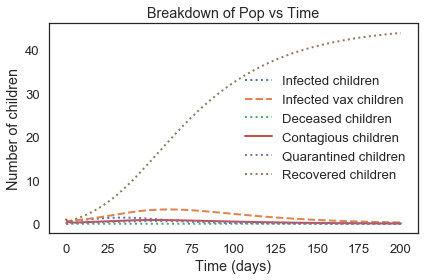

In [162]:
system = make_system3(200,300,1,.97)
results = run_simulation(system, update_func3)

plot_results3(results)

<h2>Sweeping Vaccination Rates</h2>

The model's predictions are more reasonable now, so let's sweep vaccination rates to try to find the rate at which herd immunity is attained.

In [163]:
def sweep_vaxes(time, size, vax_array):
    """Sweep a range of values for taxes.
    
    tax_array: Array of tax values
    tax_func: Function that calculates the effect of taxes on the initiation and quit rates

    returns: SweepSeries that maps from percent tax to total deaths at end of time period
    """
    sweep = SweepSeries()
    for vax in vax_array:
        system = make_system3(time, size, 1, vax)
        results = run_simulation(system, update_func3)
        sweep[vax] = results.R[system.t_end] #+ results.VI[system.t_end] + results.I[system.t_end] 
    return sweep

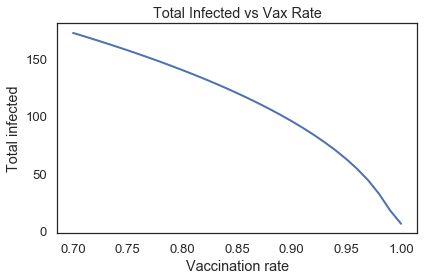

In [165]:
vax_array = linspace(.7, 1, 31)
sweep = sweep_vaxes(200, 300, vax_array)
plot(sweep)
decorate(xlabel='Vaccination rate',
         ylabel='Total infected',
         title = "Total Infected vs Vax Rate")

These predictions seem reasonable! However, there is still one big problem with the model at this point. A number of people should be a discrete value. This model is continuous, working with fractions of children rather than integer values. This means that the model predicts that higher vax rates will result in smaller outbreaks but outbreaks will still occur
because the 1 infected child will infect a fraction of a child each time step, and a fraction of that fraction will become contagious, etc.

Therefore, in order to find the vaccination rate necessary to achieve herd immunity, we must round our equations to produce integer values.

<h2>Iteration 4</h2>


In [142]:
def update_func_int(state, t, system):
    """
    Updates the model after 1 timestep (1 day)
    
    state: State object (N,C,F)
    time: Time (year)
    system: System object
    
    returns: State object(N,C,F)
    """
    unpack(system)
    s, vs, i, vi, c, q, d, r = state
    
    pop = s + vs + i + vi + r + c + q

    def min(x,y):
        if x>y:
            return y
        return x
    

    
    dSdt = -min(s, round((i_rate)*(c)*(s/pop)*((pop-q)/pop)))
    dVSdt = -min(vs, round((vi_rate)*(c)*(vs/pop)*((pop-q)/pop)))
    dIdt = -dSdt - (c_rate)*(i)
    dVIdt = -dVSdt - (c_rate)*(vi)
    dCdt = (c_rate)*(i+vi) - (q_rate)*c
    dQdt = (q_rate)*c + (d_rate)*q - (vd_rate)*q - (r_rate)*q - (vr_rate)*q
    dDdt = (d_rate)*q + (vd_rate)*q
    dRdt = (r_rate)*q + (vr_rate)*q   
    


    s += dSdt
    vs += dVSdt
    i += dIdt
    vi += dVIdt
    c += dCdt
    q += dQdt
    d += dDdt
    r += dRdt

    
    return State(S = s, VS = vs, I = i, VI = vi, C = c, Q = q, D = d, R = r)

In [143]:
def sweep_vaxes_int(time, size, vax_array):
    """Sweep a range of values for taxes.
    
    tax_array: Array of tax values
    tax_func: Function that calculates the effect of taxes on the initiation and quit rates

    returns: SweepSeries that maps from percent tax to total deaths at end of time period
    """
    sweep = SweepSeries()
    for vax in vax_array:
        system = make_system3(time, size, 1, vax)
        results = run_simulation(system, update_func_int)
        sweep[vax] = results.R[system.t_end] + results.VI[system.t_end] + results.I[system.t_end] 
    return sweep

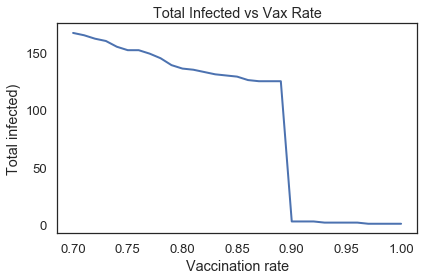

In [166]:
vax_array = linspace(.7, 1, 31)
sweep2 = sweep_vaxes_int(200, 300, vax_array)
plot(sweep2)
decorate(xlabel='Vaccination rate',
         ylabel='Total infected)',
         title = "Total Infected vs Vax Rate")

<h2>Interpretation</h2>

This makes sense. Clearly, something is happening around the 90% mark. Let's take a closer look.

In [167]:
vax_array = linspace(.89, .9, 11)
sweep2 = sweep_vaxes_int(100, 300, vax_array)
print(sweep2)

0.890    116.577325
0.891    115.577323
0.892    115.577145
0.893    115.577145
0.894    115.577512
0.895    115.577361
0.896    111.576412
0.897    110.576647
0.898      3.000224
0.899      3.000224
0.900      3.000224
dtype: float64



The model predicts that herd immunity will be achieved with a vaccination rate of about 89.8%. 

<h2>Testing the Model on Data from Samoa</h2>

I will test the model using information about an ongoing measles outbreak in Samoa. Last year, two Samoan infants died after being given vaccines which were prepared incorrectly. Apprehension surrounding vaccines soared and the government briefly shut down their vaccination program, resulting in a decrease in vaccination rates from 74% to 34%. However, since we are not working with infants, the vaccination rate rests at 74%.

I found that the death rate of measles in Samoa is 14.2 deaths per 1000 cases, and thus the recovery rate to be 985.8 recoveries per 1000 cases. Since I still do not have data regarding the difference in death and recovery rates in the vaccinated population, I assume the vaccinated population to have a death rate 20% lower and a recovery rate 20% higher than that of the unvaccinated population.

All other rates will not change. I will run a simulation for 61 days on about 30000 people, because this is how long it has been since the beginning of the outbreak and the population of children in Samoa, respectively.

In [172]:
def make_system_samoa(t_end, S_init, I_init, vax_rate):
    """ 
    Makes a system object
        
    t_0: First day of outbreak
    t_end: Last day of predictions
    S: Susceptible unvaccinated children
    VS: Susceptible vaccinated children
    I: Infected unvaccinated children
    VI: Infected vaccinated children
    C: Contagious children
    Q: Quarantined children
    D: Deceased children
    R: Recovered children
    
    returns: System object
    """
    
    contact_rate = 16
    
    i_rate = 0.9 * contact_rate
    vi_rate = 0.027 * contact_rate
    d_rate =0.00284
    vd_rate =0.003
    c_rate = 0.1 
    q_rate = 0.5 
    r_rate =0.197 
    vr_rate =0.158 
 
    
     
    init = State(S = (S_init - S_init*vax_rate), VS = S_init*vax_rate, I = 0, VI = 0, C = I_init, Q = 0, D = 0, R = 0)
    t_0 = 0
    
    

    return System(init=init, t_0=t_0, t_end=t_end, vax_rate = vax_rate, i_rate = i_rate, vi_rate = vi_rate, d_rate = d_rate, vd_rate = vd_rate, c_rate = c_rate, q_rate = q_rate, r_rate = r_rate, vr_rate = vr_rate)  

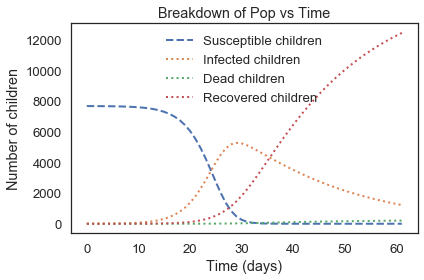

In [173]:
samoa2 = make_system_samoa(61,29533,1,.74)
results_samoa = run_simulation(samoa2, update_func3)

plot_results(results_samoa)

<h1>Interpretation</h1>

The model predicts a much higher number of Samoan children infected as of today than data suggests. There have been about 5080 cases total since  This makes sense to a certan extent. Since the beginning of the outbreak, the Samoan government enacted numerous measures to stop the spread of the disease. As of November 19th, all schools were closed and children were banned from attending public gatherings. As of December 5th, mass door-to-door vaccination and were imposed. The results of the model show how important these efforts proved to be, saving almost 322 lives. If I were to focus on Samoa, I might add these factors to the model. However, I chose to focus on finding the vaccination rate required to achieve herd immunity. 

Through sweeping various rates using my integer model, I was able to pinpoint a specific rate of 89.9% required to achieve a high level of immunity. According to the CDC, a vaccination rate of 93-95% is necessary to maintain herd immunity. Considering the varying sources from which I obtained my data, I am satisfied with these results.

Iteration played a large role in this model. It took lots of revisions in order for the model and its predictions to make sense. If I were to revise my model further, I would prevent it from overcounting. The model assumes that each contagious person comes into contact with 16 distinct people each they before they are quarantined. However, it is unlikely that there is no overlap here, as children of this age tend see the same people in their class each day. Therefore, there is a overestimation of infections.

As anti-vaccination sentiments spread throughout our culture, it is important to consider the facts. Without the mass vaccination efforts initiated by the Samoan government, many more children could have died. It is necessary for countries with high birth rates like Samoa to have high enough vaccination rates which attain herd immunity because infants who cannot receive the vaccine are extremely vulnerable. Out of the 72 deaths which have occured in Samoa as of December 9, 61 of them were infants. Thus, it is important that we vaccinate for those who do not have the choice.


<h2>Sources</h2>

https://www.washingtonpost.com/health/who-measles-statistics-these-five-countries-have-the-most-cases-but-the-us-is-struggling-with-the-disease-too/2019/12/13/79835d2a-1c5a-11ea-b4c1-fd0d91b60d9e_story.html

https://www.cdc.gov/measles/about/history.html

https://www.cdc.gov/vaccines/pubs/pinkbook/meas.html

https://www.cdc.gov/measles/downloads/measlesdataandstatsslideset.pdf

https://www.who.int/news-room/fact-sheets/detail/measles

https://reliefweb.int/disaster/ep-2019-000139-wsm

https://www.indexmundi.com/samoa/demographics_profile.html

https://www.abc.net.au/news/2019-12-09/anatomy-of-an-epidemic:-how-measles-took-hold-of-samoa/11773018

https://www.newscientist.com/article/2226441-samoan-government-takes-drastic-measures-to-fight-measles-outbreak/#ixzz67XPi8QJS

http://theconversation.com/measles-in-samoa-how-a-small-island-nation-found-itself-in-the-grips-of-an-outbreak-disaster-128467
